# Analyses of reconstruction error


### "Do circle-reconstructions differ as a function of distance to the gaussian center?"


In [49]:
import torch
import pickle

from torchvision import transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.dspritesb import dSpriteBackgroundDataset
from bVAE.models import staticVAE32, beta_from_normalized_beta
ds = dSpriteBackgroundDataset(transform=transforms.Resize(32),shapetype = 'circle')

In [4]:
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.stats import gaussian_kde as kde

# makeColours creates colors each point in a set of points (2D) based on their estimated density
# insideCircleErrorByDist.shape -> [N, 2]
# densObj0 = kde( insideCircleErrorByDist.T )
# cols0 = makeColours(densObj0.evaluate(insideCircleErrorByDist.T))

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )
    colours = [cm.ScalarMappable( norm=norm, cmap='viridis').to_rgba( val ) for val in vals]
    return colours

In [5]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)
N = 1 * 32 * 32
M = 4

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])

['betanorm = 0.001 / beta = 0.3']
['betanorm = 0.005 / beta = 1.4']
['betanorm = 0.030 / beta = 7.7']
['betanorm = 0.166 / beta = 42.4']
['betanorm = 0.910 / beta = 233.0']
['betanorm = 5.000 / beta = 1280.0']


### model: bVAE


In [9]:
vae = list()
training_stats = list()
for ii,beta_norm in enumerate(normalized_beta_values):

    # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
    beta_norm_str = '%0.4f' % (beta_norm)
    while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
        beta_norm_str = beta_norm_str[:-1]
    
    trainedpath = '../bVAE/trained/staticvae32_betanorm=%s_dsprites_circle_last_500K' % (beta_norm_str)
    trainstatspath = '../bVAE/trained/staticvae32_betanorm=%s_dsprites_circle_500K.pkl' % (beta_norm_str)
    
    vae.append(staticVAE32(n_latent = 4))
    checkpoint = torch.load(trainedpath)
    vae[ii].load_state_dict(checkpoint['model_states']['net'])

    training_stats.append(pickle.load(open(trainstatspath, 'rb')))

### Plot reconstruction error for object, edge of object, background for different configurations of object and background

#### compute errors

loop across an equidistantly spaced 4D grid (objx,objy,backx,backy) and compute reconstruction error for each of the samples


### the next cell has already been precomputed and can be loaded (if you want) - it takes a while to compute

In [34]:
# points at which the reconstruction error should be assessed
x_ = np.linspace(0, 1., 8)
y_ = np.linspace(0, 1., 8)
X, Y = np.meshgrid(x_,y_)
n_xg = len(x_)
n_yg = len(y_)

insideCircleErrorL = list()
edgeCircleErrorL = list()
backgroundErrorL = list()
insideCircleErrorByDistL = list()
backgroundErrorByDistL = list()
edgeCircleErrorByDistL = list()

for im, vae_ in enumerate(vae):

    # reconstruction error by x,y of gaussian and x,y of circle
    insideCircleError = np.zeros((n_xg,n_yg,n_xg,n_yg))
    edgeCircleError = np.zeros((n_xg,n_yg,n_xg,n_yg))
    backgroundError = np.zeros((n_xg,n_yg,n_xg,n_yg))

    # will contain a list of [distance_between_circle_and_gaussian, recon_error] paris
    insideCircleErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))
    edgeCircleErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))
    backgroundErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))

    cnt = 0
    for ixgauss, x_gauss in enumerate(x_):
        for iygauss, y_gauss in enumerate(y_):

            for ixcirc, x_circ in enumerate(x_):
                for iycirc, y_circ in enumerate(y_):

                    x = ds.arbitraryCircle(objx = x_circ, objy = y_circ, backx = x_gauss, backy = y_gauss)
                    mu,_ = vae_.encode(x)    
                    recon = vae_.decode(mu)

                    backgroundMask, objectMask, insideObjectMask, objectEdgeMask = ds.getCircleSegmentationMasks(x_circ,y_circ)

                    err = torch.pow(x - recon,2)

                    insideCircleError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[insideObjectMask])
                    edgeCircleError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[objectEdgeMask])
                    backgroundError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[backgroundMask])

                    actdist = np.sqrt((x_gauss-x_circ)**2 + (y_gauss-y_circ)**2)
                    insideCircleErrorByDist[cnt,0] = actdist
                    insideCircleErrorByDist[cnt,1] = insideCircleError[ixgauss,iygauss,ixcirc,iycirc]
                    backgroundErrorByDist[cnt,0] = actdist
                    backgroundErrorByDist[cnt,1] = backgroundError[ixgauss,iygauss,ixcirc,iycirc]
                    edgeCircleErrorByDist[cnt,0] = actdist
                    edgeCircleErrorByDist[cnt,1] = edgeCircleError[ixgauss,iygauss,ixcirc,iycirc]

                    cnt += 1
       
    insideCircleErrorL.append(insideCircleError)
    edgeCircleErrorL.append(edgeCircleError)
    backgroundErrorL.append(backgroundError)
    insideCircleErrorByDistL.append(insideCircleErrorByDist)
    backgroundErrorByDistL.append(backgroundErrorByDist)
    edgeCircleErrorByDistL.append(edgeCircleErrorByDist)

    
with open('bVAE_reconstructionerror_results.pkl', 'wb') as f:
    pickle.dump(insideCircleErrorL, f)
    pickle.dump(edgeCircleErrorL, f)
    pickle.dump(backgroundErrorL, f)
    pickle.dump(insideCircleErrorByDistL, f)
    pickle.dump(backgroundErrorByDistL, f)
    pickle.dump(edgeCircleErrorByDistL, f)    

/home/benjamin/anaconda3/envs/deepl10/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


##### You would only need to load the results here

In [36]:
with open('bVAE_reconstructionerror_results.pkl', 'rb') as f:
    insideCircleErrorL = pickle.load(f)
    edgeCircleErrorL = pickle.load(f)
    backgroundErrorL = pickle.load(f)
    insideCircleErrorByDistL = pickle.load(f)
    backgroundErrorByDistL = pickle.load(f)
    edgeCircleErrorByDistL = pickle.load(f)

# insideCircleErrorL is a list of length(vae)
# insideCircleErrorL[0] contains a n x n x n x n array of reconstruction errors inside the small circle for the first bVAE (beta = 0.3)
# n refers to the number of sampling points per dimension of the data


In [86]:
inside_mean_error = np.zeros((len(vae)))
edge_mean_error = np.zeros((len(vae)))
background_mean_error = np.zeros((len(vae)))
for ii in range(len(vae)):
    inside_mean_error[ii] = np.mean(insideCircleErrorL[ii])
    edge_mean_error[ii] = np.mean(edgeCircleErrorL[ii])
    background_mean_error[ii] = np.mean(backgroundErrorL[ii])

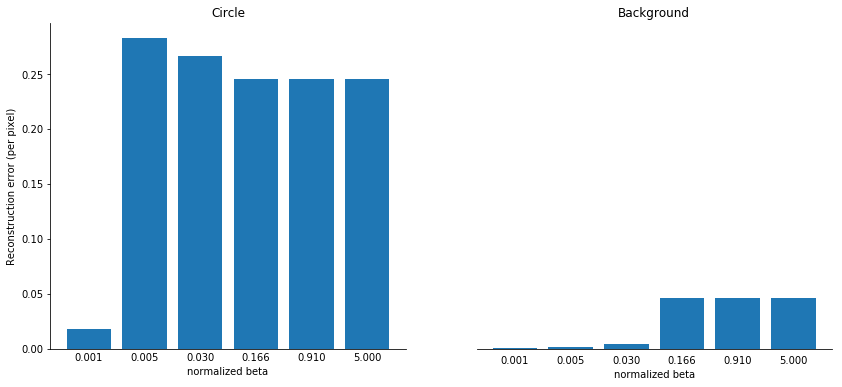

In [40]:
labels = ['{:.3f}'.format(normalized_beta_value) for ii, normalized_beta_value in enumerate(normalized_beta_values)]

_,ax = plt.subplots(1,2,figsize=(14,6),sharey=True, sharex=True)
ax[0].bar(np.arange(len(vae)), inside_mean_error)
ax[0].set_title('Circle')
ax[0].set(xlabel='normalized beta')
ax[0].set(ylabel='Reconstruction error (per pixel)')
plt.xticks(range(len(vae)), labels, rotation='horizontal', fontsize='10')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params(axis='x', length=0)

ax[1].bar(range(len(vae)), background_mean_error)
ax[1].set_title('Background')
ax[1].set(xlabel='normalized beta')
# plt.xticks(range(len(vae)), labels, rotation='horizontal', fontsize='10')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
plt.tick_params(top='off', bottom='off', left='off', right='off')#, labelleft='off', labelbottom='on')

([<matplotlib.axis.XTick at 0x7fb84eb40400>,
 <a list of 6 Text xticklabel objects>)

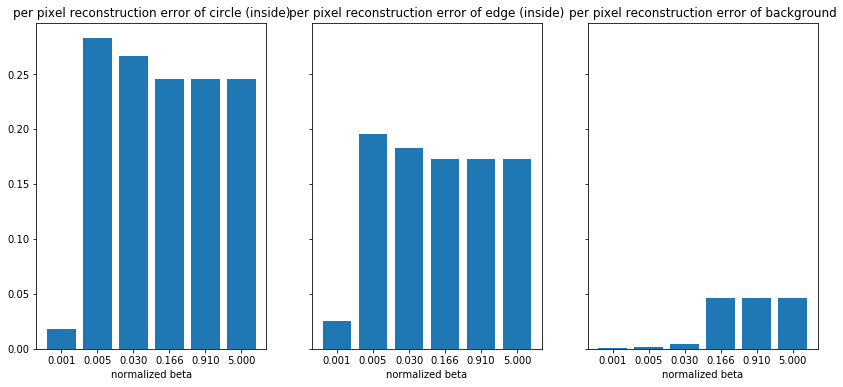

In [88]:
labels = ['{:.3f}'.format(normalized_beta_value) for ii, normalized_beta_value in enumerate(normalized_beta_values)]

_,ax = plt.subplots(1,3,figsize=(14,6),sharey=True, sharex=True)
ax[0].bar(np.arange(len(vae)), inside_mean_error)
ax[0].set_title('per pixel reconstruction error of circle (inside)')
ax[0].set(xlabel='normalized beta')
plt.xticks(range(len(vae)), labels, rotation='horizontal', fontsize='10')

ax[1].bar(np.arange(len(vae)), edge_mean_error)
ax[1].set_title('per pixel reconstruction error of edge (inside)')
ax[1].set(xlabel='normalized beta')
plt.xticks(range(len(vae)), labels, rotation='horizontal', fontsize='10')

ax[2].bar(range(len(vae)), background_mean_error)
ax[2].set_title('per pixel reconstruction error of background')
ax[2].set(xlabel='normalized beta')
plt.xticks(range(len(vae)), labels, rotation='horizontal', fontsize='10')
